### Molecule hematoencephalic barrier permeability prediction with message-passing neural network (MPNN)

Blood brain barrier permeability is the property of the whole molecule, therefore we will have a simple binary clasification problem for the whole molecule. We will use MPNN, which mainly in addition to basic GNN tends to specifically learn aggregation sequences/patterns between aggregation steps in a molecule graph. This additional capacity mainly will be implemented via gated recurrent unit (GRU).

### References

[Keras examples by Alexander Kensert](https://keras.io/examples/graph/mpnn-molecular-graphs) <br>
[Graph Neural Networks](https://arxiv.org/abs/1901.00596) <br>
[Applications of GNN](https://arxiv.org/abs/1812.08434)<br>
[MPNN](https://arxiv.org/abs/1704.01212) <br>
[MPNNModel](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#mpnnmodel)<br>


In [22]:
!pip -q install rdkit-pypi
#!pip install deepchem          # including: for scaffold splitting version etc.
!pip -q install pandas
!pip -q install Pillow
!pip -q install matplotlib
!pip -q install pydot
!sudo apt-get -qq install graphviz

In [23]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
# import shutil 
# import deepchem as dc
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

np.random.seed(42)
tf.random.set_seed(42)

# avoid tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# avoid warnings
warnings.filterwarnings("ignore")
# avoid RDKit logs
RDLogger.DisableLog("rdApp.*")

### MoleculeNet dataset will be used

[MoleculeNet.org](https://moleculenet.org/datasets-1).


In [46]:
csv = keras.utils.get_file(
    "BBBP.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
)

df = pd.read_csv(csv, usecols=[1, 2, 3])
df.iloc[17:37]

,name,p_np,smiles
17,hyoscyamine,1,CN1C2CCC1CC(C2)OC(=O)[C@H](CO)c3ccccc3
18,glyburide,1,COc1ccc(Cl)cc1C(=O)NCCc2ccc(cc2)[S](=O)(=O)NC(...
19,lamotrigine,1,Nc1nnc(c(N)n1)c2cccc(Cl)c2Cl
20,2-Methylpentane,1,CCCC(C)C
21,Dexamfetamine,1,C[C@H](N)Cc1ccccc1
22,SKF-93619,0,c1cc2c(cc(CC3=CNC(=NC3=O)NCCSCc3oc(cc3)CN(C)C)...
23,nadolol,1,CC(C)(C)NCC(O)COc1cccc2C[C@@H](O)[C@@H](O)Cc12
24,sufentanil,1,CCC(=O)N(c1ccccc1)C2(CCN(CCc3sccc3)CC2)COC
25,12,0,CCNC(=NC#N)NCCSCc1c(cccn1)Br
26,zolpidem,1,CN(C)C(=O)Cc1n2cc(C)ccc2nc1c3ccc(C)cc3


### Atom features will be:
symbol of the element,<br>
number of valence electrons,<br>
number of hydrogen bonds,<br>
orbital hybridization 

### Bond features will be:
bond type, <br>
conjugation

In [25]:

class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()

atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [26]:

def molecule_from_smiles(smiles):
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

def graph_from_molecule(molecule):

    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # create self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):

    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

# we first shuffle data, then split it in trainset=80%, validset=18% and testset=2%
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].p_np

valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.98)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].p_np

test_index = permuted_indices[int(df.shape[0] * 0.98) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

##### Alternative using Scaffold splitting as recommended in the paper tox example just for versatility #####

# def load_toxcast(featurizer='ECFP', split='index'):

#   current_dir = os.path.dirname(os.path.realpath(__file__))

#   # Load TOXCAST dataset
#   print("About to load TOXCAST dataset.")
#   dataset_file = os.path.join(
#       current_dir, "./processing/toxcast_data.csv.gz")
#   dataset = dc.utils.save.load_from_disk(dataset_file)
#   print("Columns of dataset: %s" % str(dataset.columns.values))
#   print("Number of examples in dataset: %s" % str(dataset.shape[0]))

#   # Featurize TOXCAST dataset
#   print("About to featurize TOXCAST dataset.")

#   if featurizer == 'ECFP':
#       featurizer = dc.feat.CircularFingerprint(size=1024)
#   elif featurizer == 'GraphConv':
#       featurizer = dc.feat.ConvMolFeaturizer()

#   TOXCAST_tasks = dataset.columns.values[1:].tolist()

#   loader = dc.data.CSVLoader(
#       tasks=TOXCAST_tasks, smiles_field="smiles", featurizer=featurizer)
#   dataset = loader.featurize(dataset_file)

#   # Initialize transformers 
#   transformers = [
#       dc.trans.BalancingTransformer(transform_w=True, dataset=dataset)]
#   print("About to transform data")
#   for transformer in transformers:
#     dataset = transformer.transform(dataset)

#   splitters = {'index': dc.splits.IndexSplitter(),
#                'random': dc.splits.RandomSplitter(),
#                'scaffold': dc.splits.ScaffoldSplitter()}
#   splitter = splitters[split]

#   train, valid, test = splitter.train_valid_test_split(dataset)
  
#   return TOXCAST_tasks, (train, valid, test), transformers

In [27]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)


Graph (including self-loops):
	atom features	 (17, 29)
	bond features	 (53, 7)
	pair indices	 (53, 2)


Name:	chlorothiazide
SMILES:	N[S](=O)(=O)c1cc2c(NC=N[S]2(=O)=O)cc1Cl
BBBP:	0
Molecule:


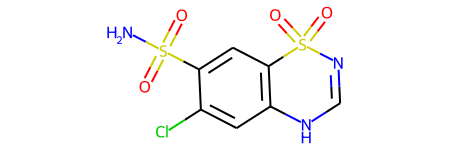

In [28]:
print(f"Name:\t{df.name[150]}\nSMILES:\t{df.smiles[150]}\nBBBP:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[150].smiles)
print("Molecule:")
molecule

In [29]:
def prepare_batch(x_batch, y_batch):
    # Merges (sub)graphs of batch into a single global (disconnected) graph
    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)


In [30]:

class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [31]:

class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)


In [ ]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)


In [ ]:
keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

### Training

Epoch 1/40
52/52 - 15s - loss: 0.5584 - AUC: 0.6490 - val_loss: 0.4813 - val_AUC: 0.8299 - 15s/epoch - 280ms/step
Epoch 2/40
52/52 - 3s - loss: 0.4814 - AUC: 0.7722 - val_loss: 0.6208 - val_AUC: 0.8411 - 3s/epoch - 67ms/step
Epoch 3/40
52/52 - 3s - loss: 0.4614 - AUC: 0.7950 - val_loss: 0.5193 - val_AUC: 0.8465 - 3s/epoch - 51ms/step
Epoch 4/40
52/52 - 3s - loss: 0.4488 - AUC: 0.8084 - val_loss: 0.5067 - val_AUC: 0.8510 - 3s/epoch - 64ms/step
Epoch 5/40
52/52 - 3s - loss: 0.4399 - AUC: 0.8182 - val_loss: 0.4710 - val_AUC: 0.8529 - 3s/epoch - 61ms/step
Epoch 6/40
52/52 - 3s - loss: 0.4299 - AUC: 0.8282 - val_loss: 0.4689 - val_AUC: 0.8373 - 3s/epoch - 65ms/step
Epoch 7/40
52/52 - 3s - loss: 0.4316 - AUC: 0.8295 - val_loss: 0.5190 - val_AUC: 0.8591 - 3s/epoch - 64ms/step
Epoch 8/40
52/52 - 3s - loss: 0.4226 - AUC: 0.8317 - val_loss: 0.4429 - val_AUC: 0.8708 - 3s/epoch - 62ms/step
Epoch 9/40
52/52 - 3s - loss: 0.4117 - AUC: 0.8421 - val_loss: 0.4475 - val_AUC: 0.8709 - 3s/epoch - 62ms/ste

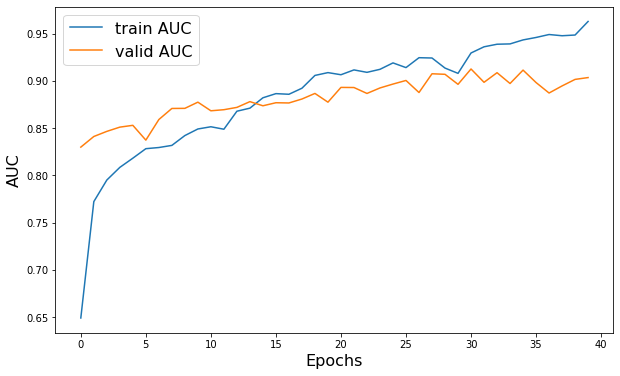

In [33]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    class_weight={0: 2.0, 1: 0.5},
)

plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

### Prediction

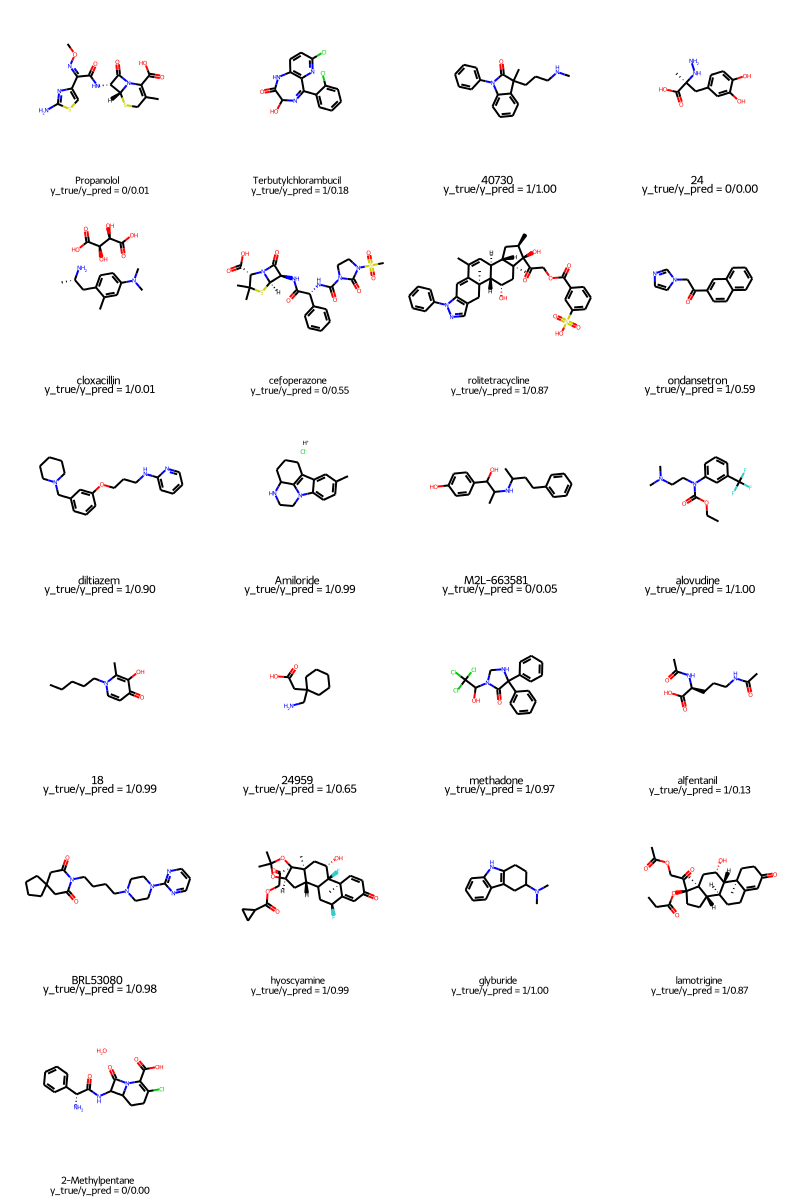

In [51]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"{df.name[i]}\n y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)